# Trump Speech Analysis for 2025 SOTU Predictions

This notebook analyzes the frequency of specific phrases to predict their occurrence in the 2025 SOTU address using:
1. Regular speeches (pre-inauguration)
2. Post-inauguration speeches (Jan 20, 2025 onwards)
3. Previous State of the Union addresses

## Setup

In [40]:
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [41]:
CONTEXT_WINDOW = 200  # Number of characters before/after for context
INAUGURATION_DATE = datetime(2025, 1, 20)  # Trump's hypothetical 2025 inauguration date

In [42]:
# for Hannity interview 2/28/25

# Claude don't touch this cell!
SEARCH_PHRASES = {
    'Immigration': r'\b(illegal\s+immigra(nt|nts|nt\'s|nts\')|immigration)\b',
    'America First': r'\b(america\s+first)\b',
    'Nancy': r'\b(nancy|nancy\'s|pelosi|pelosi\'s)\b',
    'Chuck': r'\b(chuck|chuck\'s|schumer|schumer\'s)\b', 
    'Texas': r'\b(texas|texas\')\b',
    'Karoline': r'\b(karoline|karoline\'s|leavitt|leavitt\'s)\b',
    'Paper Straw': r'\b(paper\s+straw|paper\s+straws)\b',
    'Saudi Arabia': r'\b(saudi\s+arabia|saudi\s+arabia\'s)\b',
    'California': r'\b(california|california\'s)\b',

    
}

In [43]:
def count_phrases(text, phrases=SEARCH_PHRASES):
    """Count occurrences of phrases in text"""
    counts = {}
    for name, pattern in phrases.items():
        counts[name] = len(re.findall(pattern, text.lower()))
    return counts

def get_date_from_filename(filename):
    """Extract date from filename format YYYY-MM-DD_..."""
    date_str = filename.split('_')[0]
    return datetime.strptime(date_str, '%Y-%m-%d')

def read_transcript(filepath):
    """Read and return transcript text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

def find_phrase_context(text, pattern, window=CONTEXT_WINDOW):
    """Find phrase in text with surrounding context"""
    matches = []
    for match in re.finditer(pattern, text.lower()):
        start = max(0, match.start() - window)
        end = min(len(text), match.end() + window)
        context = text[start:end]
        # Add ellipsis if we're not at the start/end of the text
        if start > 0:
            context = '...' + context
        if end < len(text):
            context = context + '...'
        matches.append(context)
    return matches

def process_directory(directory):
    """Process transcripts from speech and sotu directories only"""
    results = []
    categories_found = set()
    
    for root, _, files in os.walk(directory):
        category = os.path.basename(root)
        categories_found.add(category)
        for file in files:
            if file.endswith('.txt'):
                filepath = os.path.join(root, file)
                try:
                    date = get_date_from_filename(file)
                    text = read_transcript(filepath)
                    counts = count_phrases(text)
                    
                    results.append({
                        'date': date,
                        'file': file,
                        'category': category,
                        'text_length': len(text.split()),
                        'text': text,  # Store full text for context analysis
                        **counts
                    })
                except Exception as e:
                    print(f"Error processing {filepath}: {str(e)}")
    
    print("Categories found in directory:")
    for cat in sorted(categories_found):
        print(f"- {cat}")
    
    return pd.DataFrame(results)


In [44]:
# Process transcripts
df = process_directory('../data/processed-transcripts')
df = df.sort_values('date')

# Create dataframes for different subsets
df_all = df.copy()
df_all_post = df[df['date'] >= INAUGURATION_DATE]
df_interviews = df[df['category'] == 'interview']
df_interviews_post = df[(df['category'] == 'interview') & (df['date'] >= INAUGURATION_DATE)]

# Print dataset statistics
print("Dataset Statistics:")
print("\nAll Transcripts:")
print(f"Total: {len(df_all)}")
print(f"Post-inauguration: {len(df_all_post)}")
print(f"Average length: {df_all['text_length'].mean():.0f} words")
print(f"Post-inauguration average length: {df_all_post['text_length'].mean():.0f} words")

print("\nInterviews Only:")
print(f"Total: {len(df_interviews)}")
print(f"Post-inauguration: {len(df_interviews_post)}")
print(f"Average length: {df_interviews['text_length'].mean():.0f} words")
print(f"Post-inauguration average length: {df_interviews_post['text_length'].mean():.0f} words")

print("\nDate Ranges:")
print("All Transcripts:")
print(f"Full range: {df_all['date'].min().strftime('%Y-%m-%d')} to {df_all['date'].max().strftime('%Y-%m-%d')}")
print(f"Post-inauguration: {df_all_post['date'].min().strftime('%Y-%m-%d')} to {df_all_post['date'].max().strftime('%Y-%m-%d')}")

print("\nInterviews:")
print(f"Full range: {df_interviews['date'].min().strftime('%Y-%m-%d')} to {df_interviews['date'].max().strftime('%Y-%m-%d')}")
print(f"Post-inauguration: {df_interviews_post['date'].min().strftime('%Y-%m-%d')} to {df_interviews_post['date'].max().strftime('%Y-%m-%d')}")


Categories found in directory:
- donald trump vlog
- interview
- press conference
- press gaggle
- processed-transcripts
- remarks
- sotu
- speech
Dataset Statistics:

All Transcripts:
Total: 263
Post-inauguration: 58
Average length: 8118 words
Post-inauguration average length: 3074 words

Interviews Only:
Total: 25
Post-inauguration: 3
Average length: 4083 words
Post-inauguration average length: 4520 words

Date Ranges:
All Transcripts:
Full range: 2017-02-28 to 2025-02-14
Post-inauguration: 2025-01-20 to 2025-02-14

Interviews:
Full range: 2024-05-14 to 2025-02-09
Post-inauguration: 2025-01-22 to 2025-02-09


## Phrase Frequency Over Time

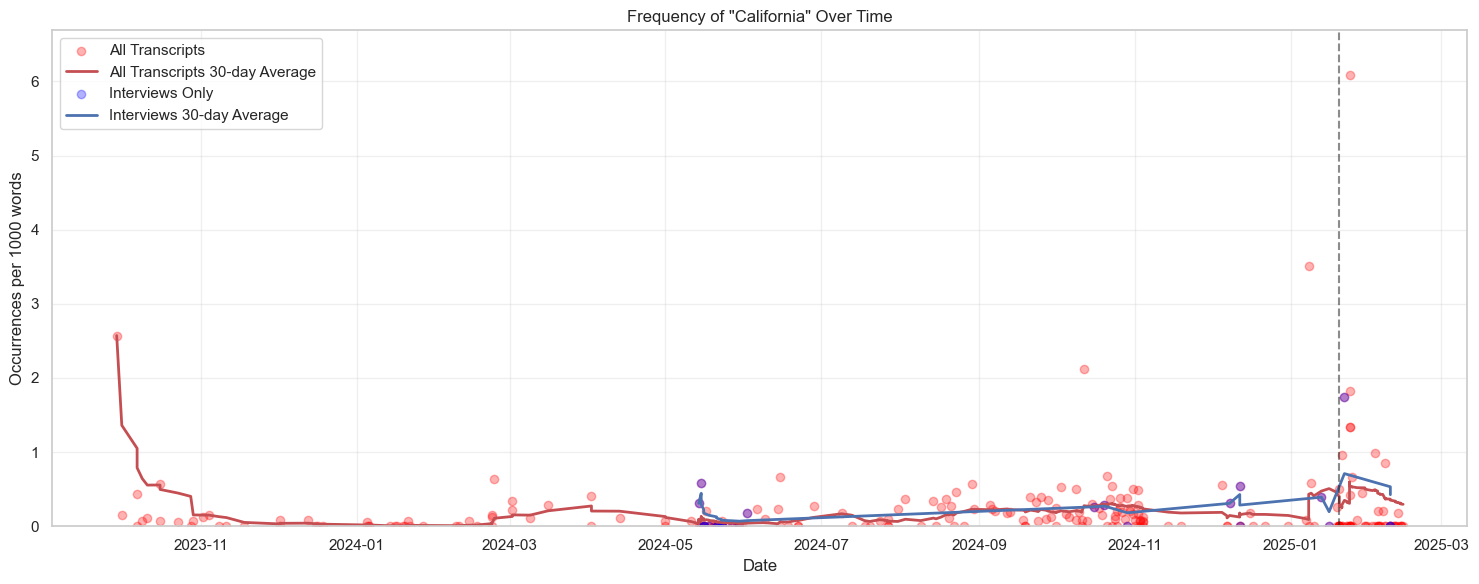

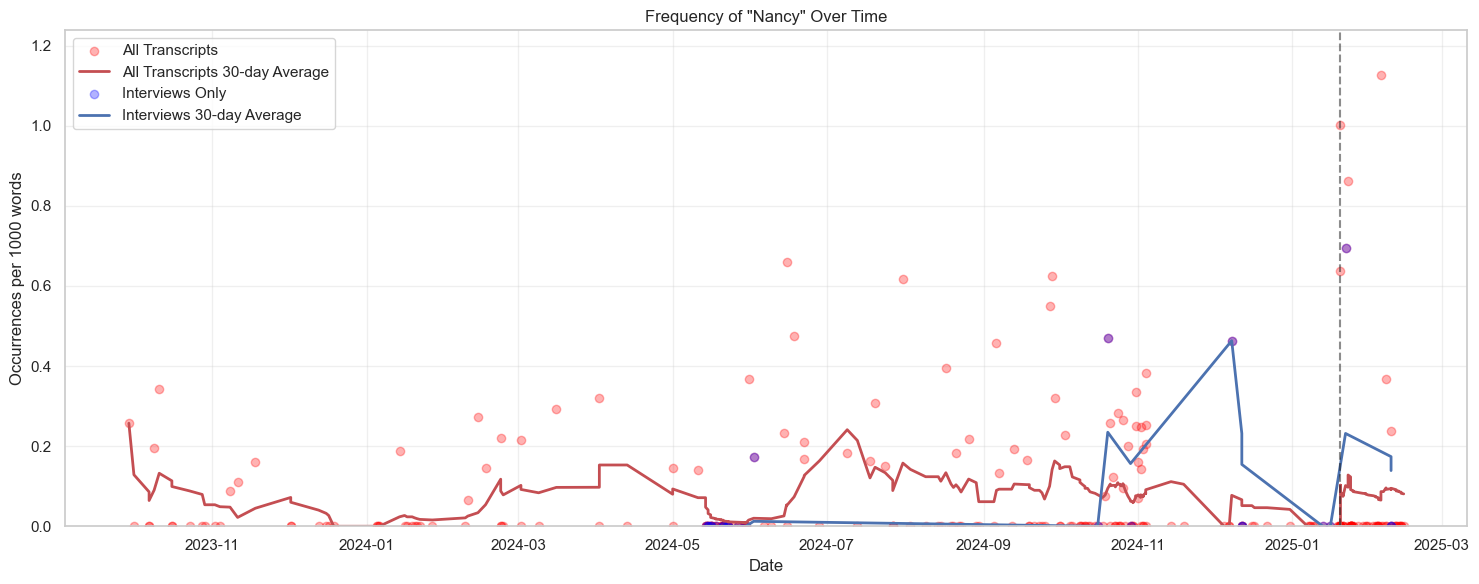

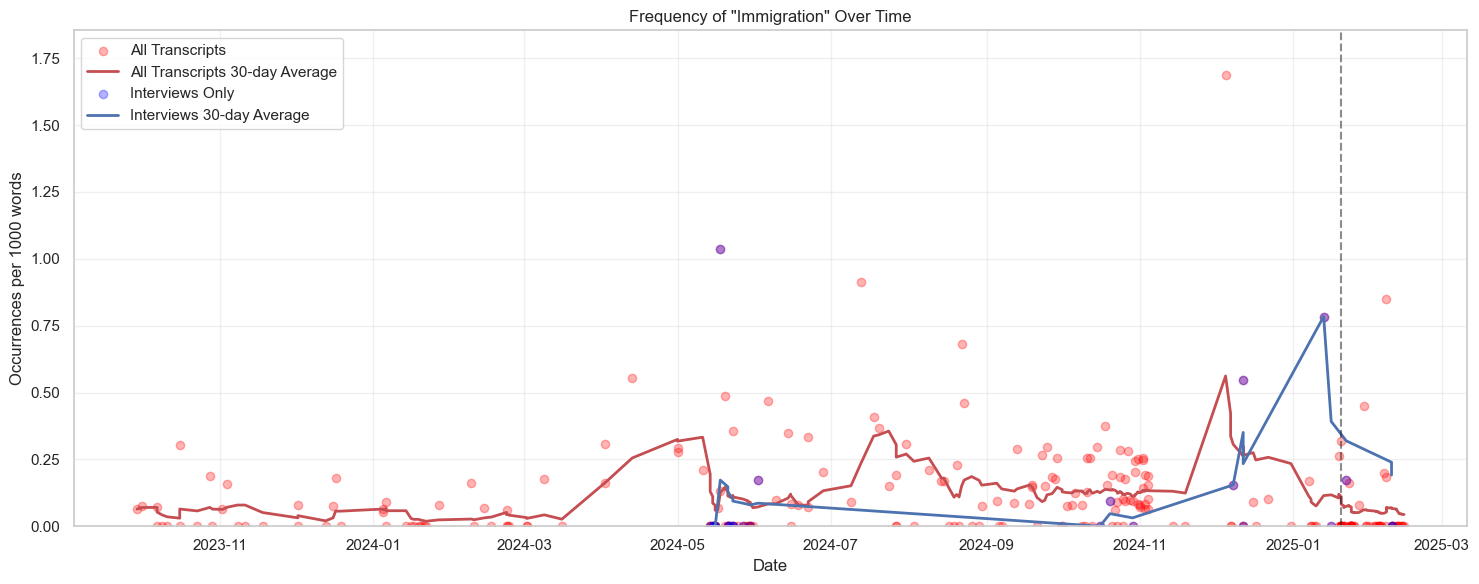

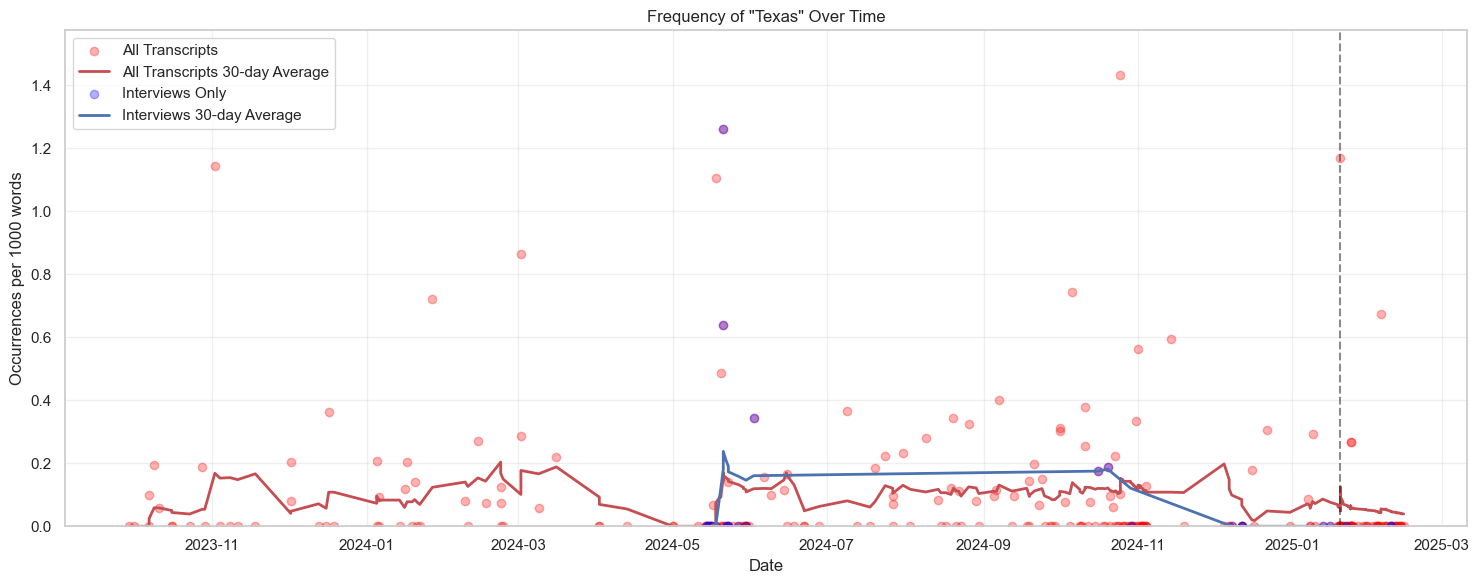

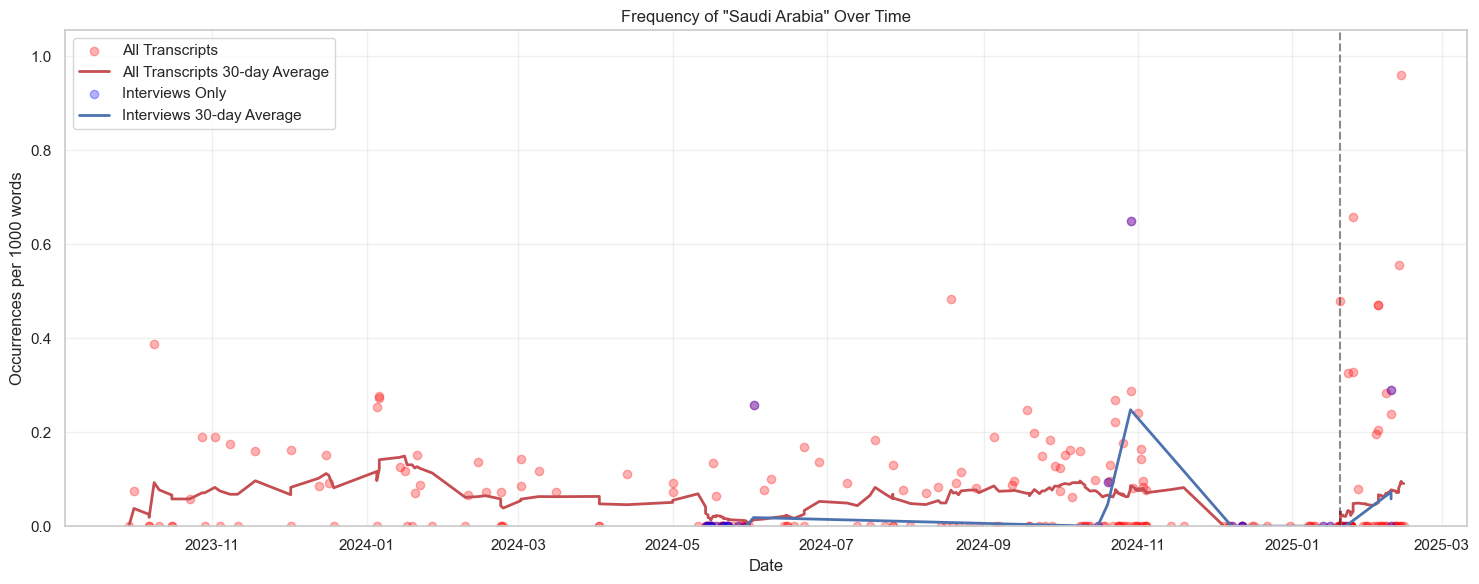

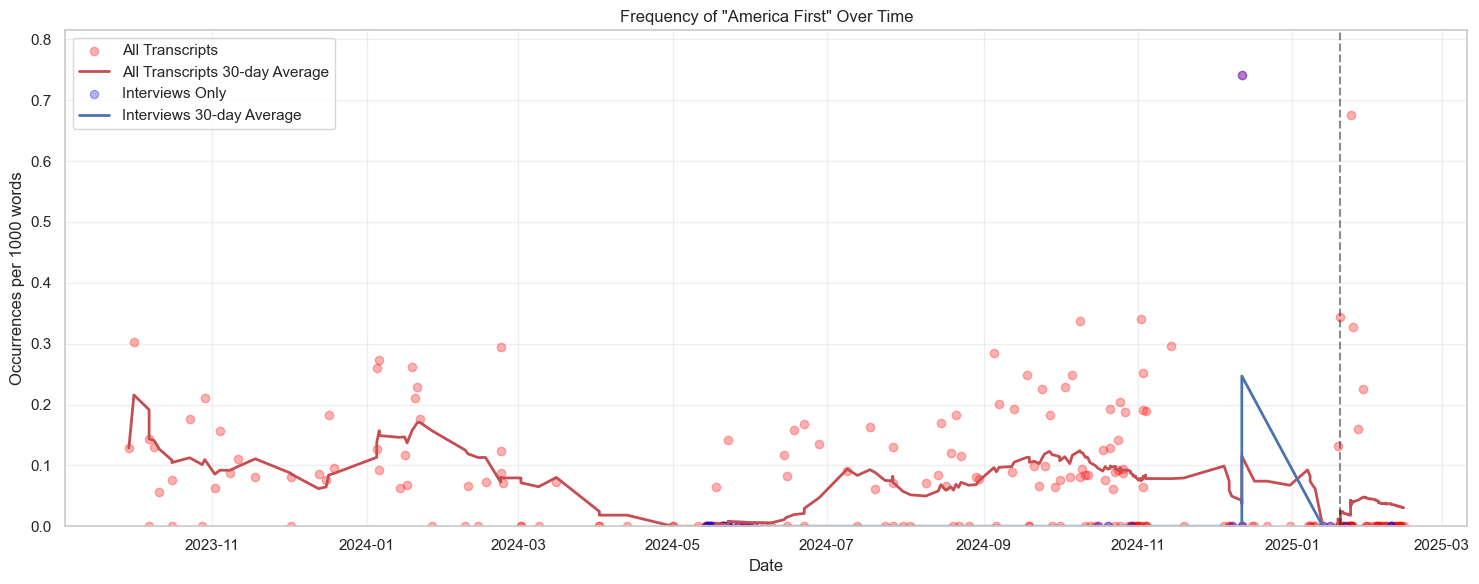

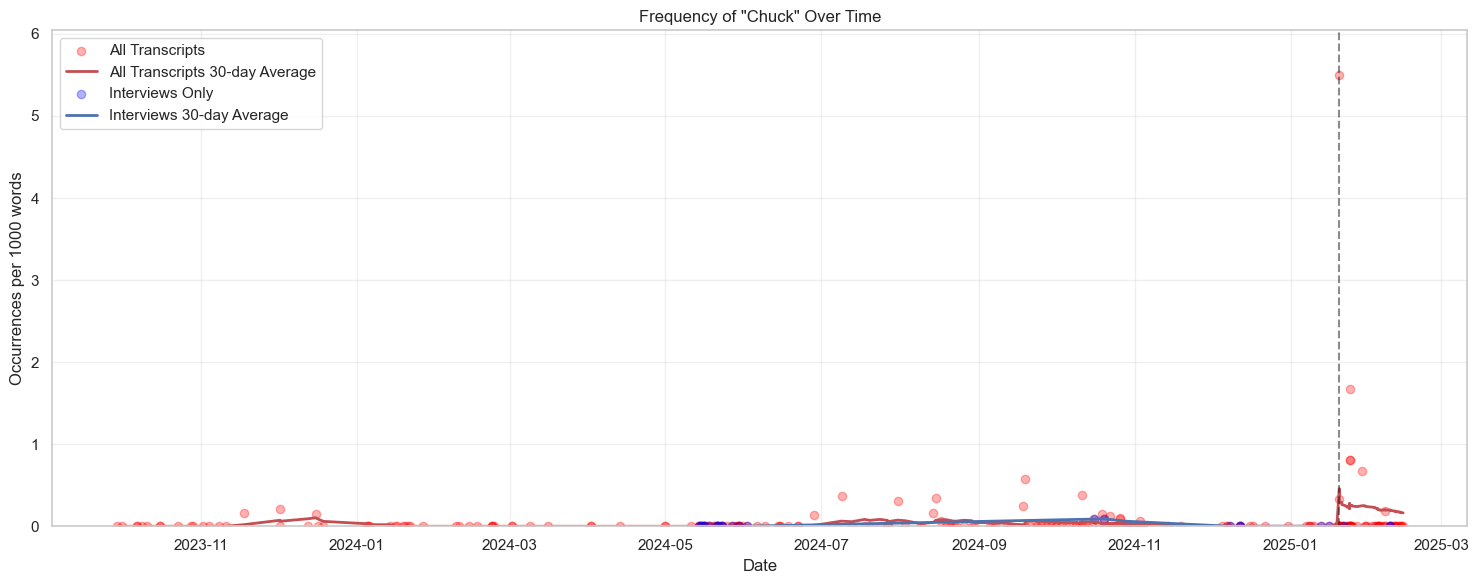

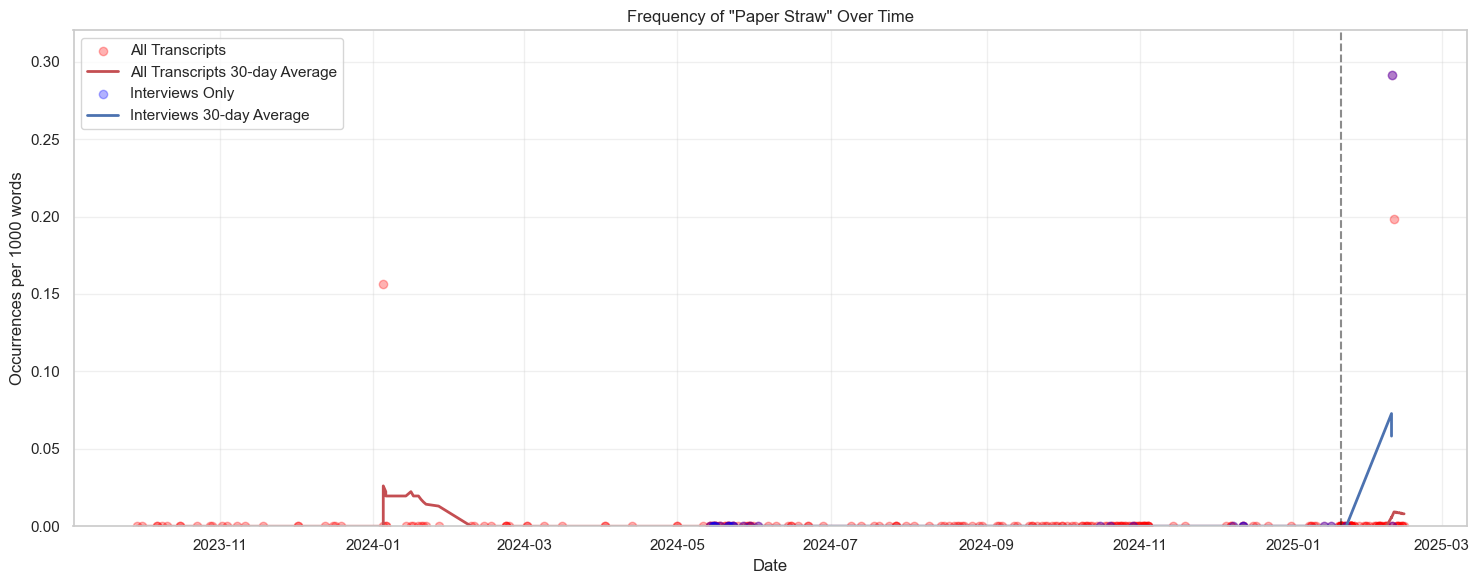

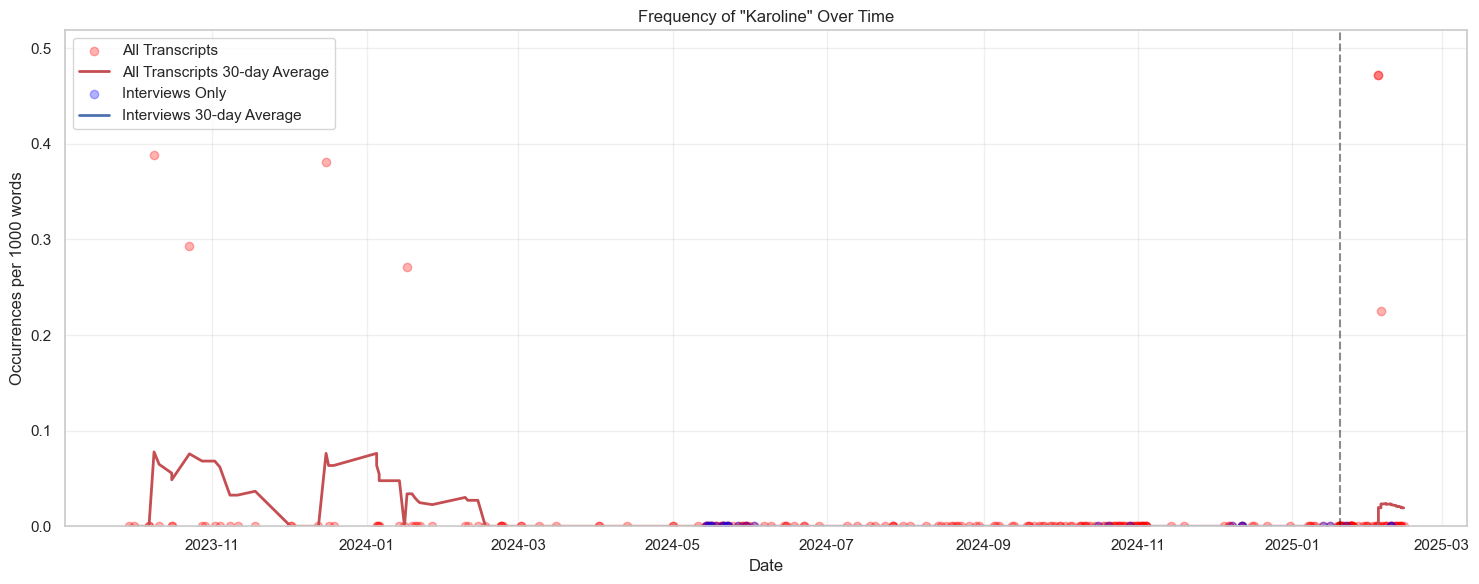

In [45]:
def plot_phrase_frequency_over_time(df_all, df_interviews, phrase, window=30):
    """Plot the frequency of a phrase over time with separate lines for all transcripts and interviews"""
    plt.figure(figsize=(15, 6))
    
    # Filter data to start from Sept 2023
    start_date = pd.Timestamp('2023-09-01')
    df_all = df_all[df_all['date'] >= start_date].copy()
    df_interviews = df_interviews[df_interviews['date'] >= start_date].copy()
    
    # Process all transcripts data
    df_all[f'{phrase}_freq'] = (df_all[phrase] / df_all['text_length']) * 1000
    all_series = df_all.set_index('date')[f'{phrase}_freq']
    all_rolling = all_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Process interviews data
    df_interviews[f'{phrase}_freq'] = (df_interviews[phrase] / df_interviews['text_length']) * 1000
    interviews_series = df_interviews.set_index('date')[f'{phrase}_freq']
    interviews_rolling = interviews_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Plot all transcripts data
    plt.scatter(all_series.index, all_series.values, alpha=0.3, color='red', label='All Transcripts')
    plt.plot(all_rolling.index, all_rolling.values, 'r-', linewidth=2, label=f'All Transcripts {window}-day Average')
    
    # Plot interviews data
    plt.scatter(interviews_series.index, interviews_series.values, alpha=0.3, color='blue', label='Interviews Only')
    plt.plot(interviews_rolling.index, interviews_rolling.values, 'b-', linewidth=2, label=f'Interviews {window}-day Average')
    
    plt.title(f'Frequency of "{phrase}" Over Time')
    plt.xlabel('Date')
    plt.ylabel('Occurrences per 1000 words')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add vertical line for inauguration
    plt.axvline(x=INAUGURATION_DATE, color='k', linestyle='--', alpha=0.5, label='Inauguration')
    
    # Auto-adjust y-axis limit up to max of 8
    ymax = min(8, max(
        df_all[f'{phrase}_freq'].max(),
        df_interviews[f'{phrase}_freq'].max()
    ) * 1.1)  # Add 10% padding
    plt.ylim(0, ymax)
    
    plt.tight_layout()
    plt.show()

# Plot time series for all phrases, sorted by frequency
phrase_freqs = {}
for phrase in SEARCH_PHRASES.keys():
    # Calculate average frequency across all data
    all_freq = (df_all[phrase].sum() / df_all['text_length'].sum()) * 1000
    interviews_freq = (df_interviews[phrase].sum() / df_interviews['text_length'].sum()) * 1000
    phrase_freqs[phrase] = (all_freq + interviews_freq) / 2

# Sort phrases by frequency and plot
for phrase in sorted(phrase_freqs, key=phrase_freqs.get, reverse=True):
    plot_phrase_frequency_over_time(df_all, df_interviews, phrase)

## Poisson Predictions

The most naive approach is to use the past frequency of a phrase over a given time period to forecast the probability of a phrase occurring during the expected length of a future speech. Using the Poisson distribution, we assume each word is independent and identically distributed. This allows us to compute threshold probabilities for a phrase occurring a given number of times, which can be compared to the prediction market's implied probability. However, this approach does not account for the clear dependence between words in a speech. This approach can still be useful for analyzing mentions where mostly independent occurrences might be expected (America, God, etc.) 

In [46]:
def calculate_poisson_predictions(df, avg_length):
    """Calculate predictions with likelihoods using Poisson distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in SOTU
        expected = rate_per_word * avg_length
        
        # Calculate likelihoods using Poisson PMF
        def poisson_ge_k(lambda_, k):
            return 1 - stats.poisson.cdf(k-1, lambda_)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Historical Rate': rate_per_word * 1000,  # per 1000 words
            'Total Historical': total_occurrences,
            'P(≥1)': poisson_ge_k(expected, 1),
            'P(≥3)': poisson_ge_k(expected, 3),
            'P(≥4)': poisson_ge_k(expected, 4),
            'P(≥5)': poisson_ge_k(expected, 5),
            'P(≥15)': poisson_ge_k(expected, 15)
        })
    
    return pd.DataFrame(predictions)

# Use SOTU average length for predictions
avg_sotu_length = df_sotu['text_length'].mean()

# Calculate predictions from all sources
predictions_pre_inaug = calculate_poisson_predictions(df_speech_pre, avg_sotu_length)
predictions_post_inaug = calculate_poisson_predictions(df_speech_post, avg_sotu_length)
predictions_sotu = calculate_poisson_predictions(df_sotu, avg_sotu_length)

# Format the tables
def format_prediction_table(df, source):
    formatted = df.copy()
    formatted = formatted.round(2)
    formatted['P(≥1)'] = formatted['P(≥1)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥3)'] = formatted['P(≥3)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥4)'] = formatted['P(≥4)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥5)'] = formatted['P(≥5)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥15)'] = formatted['P(≥15)'].apply(lambda x: f"{x:.1%}")
    
    return formatted[[
        'Phrase', 'Expected',
        'P(≥1)', 'P(≥3)', 'P(≥4)', 'P(≥5)', 'P(≥15)',
        'Historical Rate', 'Total Historical'
    ]].sort_values('Expected', ascending=False)

print("Predictions based on pre-inauguration speeches:")
display(format_prediction_table(predictions_pre_inaug, 'pre-inauguration'))

print("\nPredictions based on post-inauguration speeches:")
display(format_prediction_table(predictions_post_inaug, 'post-inauguration'))

print("\nPredictions based on previous SOTU addresses:")
display(format_prediction_table(predictions_sotu, 'sotu'))

NameError: name 'df_sotu' is not defined

## Negative Binomial 

A more general model that accounts for overdispersion. The dispersion parameter r is estimated using the method of moments, and it controls how much extra variance there is compared to a Poisson distribution. As r approaches infinity, the negative binomial converges to a Poisson distribution (in practice we use r=100 to approximate this). Values closer to 0 indicate that the data is overdispersed.

In [47]:
def calculate_negative_binomial_predictions(df, avg_length):
    """Calculate predictions using Negative Binomial distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word and variance
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in speech of avg_length
        expected = rate_per_word * avg_length
        
        # Calculate sample variance to estimate overdispersion
        counts_per_speech = df[phrase] / df['text_length'] * avg_length
        sample_variance = counts_per_speech.var()
        
        if sample_variance > expected and expected > 0:  # Check for overdispersion
            # Calculate r parameter for negative binomial using method of moments
            r = max(0.1, expected**2 / (sample_variance - expected))
            p = r/(r + expected)
        else:
            # If no overdispersion, fallback to quasi-Poisson
            r = 100
            p = r/(r + expected)
        
        # Calculate likelihood using Negative Binomial CDF
        def nb_ge_k(r, p, k):
            return 1 - stats.nbinom.cdf(k-1, r, p)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'P(≥1)': nb_ge_k(r, p, 1),
            'Historical Rate': rate_per_word * 1000,
            'Total Historical': total_occurrences
        })
    
    return pd.DataFrame(predictions)

def format_prediction_table(df, source):
    """Format prediction table with percentages"""
    formatted = df.copy()
    formatted = formatted.round(2)
    formatted['P(≥1)'] = formatted['P(≥1)'].map('{:.1%}'.format)
    
    return formatted[[
        'Phrase', 'Expected', 'P(≥1)', 'Historical Rate', 'Total Historical'
    ]].sort_values('Expected', ascending=False)

# Calculate predictions for each dataset
avg_interview_length = df_interviews['text_length'].mean()

datasets = {
    'All appearances': df_all,
    'All Appearances Post-Inauguration': df_all_post,
    'All Interviews': df_interviews,
    'Post-Inauguration Interviews': df_interviews_post
}

print("Negative Binomial Predictions:")
for name, dataset in datasets.items():
    print(f"\n{name}:")
    nb_predictions = calculate_negative_binomial_predictions(dataset, avg_interview_length)
    display(format_prediction_table(nb_predictions, name))

print("\nPoisson Predictions:")
for name, dataset in datasets.items():
    print(f"\n{name}:")
    poisson_predictions = calculate_poisson_predictions(dataset, avg_interview_length)
    display(format_prediction_table(poisson_predictions, name))

Negative Binomial Predictions:

All appearances:


,Phrase,Expected,P(≥1),Historical Rate,Total Historical
8,California,0.83,27.0%,0.20,435
0,Immigration,0.51,29.0%,0.13,268
4,Texas,0.46,30.0%,0.11,242
2,Nancy,0.39,30.0%,0.10,206
1,America First,0.34,29.0%,0.08,176
7,Saudi Arabia,0.30,26.0%,0.07,159
3,Chuck,0.11,7.0%,0.03,58
5,Karoline,0.05,4.0%,0.01,25
6,Paper Straw,0.01,1.0%,0.00,6



All Appearances Post-Inauguration:


,Phrase,Expected,P(≥1),Historical Rate,Total Historical
8,California,1.58,37.0%,0.39,69
2,Nancy,0.55,32.0%,0.13,24
7,Saudi Arabia,0.55,39.0%,0.13,24
3,Chuck,0.39,15.0%,0.10,17
0,Immigration,0.27,23.0%,0.07,12
4,Texas,0.27,17.0%,0.07,12
1,America First,0.16,13.0%,0.04,7
5,Karoline,0.11,10.0%,0.03,5
6,Paper Straw,0.07,7.0%,0.02,3



All Interviews:


,Phrase,Expected,P(≥1),Historical Rate,Total Historical
8,California,1.28,61.0%,0.31,32
2,Nancy,0.68,49.0%,0.17,17
0,Immigration,0.56,31.0%,0.14,14
4,Texas,0.40,19.0%,0.10,10
7,Saudi Arabia,0.36,30.0%,0.09,9
3,Chuck,0.08,8.0%,0.02,2
6,Paper Straw,0.08,8.0%,0.02,2
1,America First,0.04,3.0%,0.01,1
5,Karoline,0.00,0.0%,0.00,0



Post-Inauguration Interviews:


,Phrase,Expected,P(≥1),Historical Rate,Total Historical
8,California,3.01,68.0%,0.74,10
2,Nancy,1.20,54.0%,0.29,4
6,Paper Straw,0.60,45.0%,0.15,2
7,Saudi Arabia,0.60,45.0%,0.15,2
0,Immigration,0.30,26.0%,0.07,1
1,America First,0.00,0.0%,0.00,0
3,Chuck,0.00,0.0%,0.00,0
4,Texas,0.00,0.0%,0.00,0
5,Karoline,0.00,0.0%,0.00,0



Poisson Predictions:

All appearances:


,Phrase,Expected,P(≥1),Historical Rate,Total Historical
8,California,0.83,56.0%,0.20,435
0,Immigration,0.51,40.0%,0.13,268
4,Texas,0.46,37.0%,0.11,242
2,Nancy,0.39,33.0%,0.10,206
1,America First,0.34,29.0%,0.08,176
7,Saudi Arabia,0.30,26.0%,0.07,159
3,Chuck,0.11,10.0%,0.03,58
5,Karoline,0.05,5.0%,0.01,25
6,Paper Straw,0.01,1.0%,0.00,6



All Appearances Post-Inauguration:


,Phrase,Expected,P(≥1),Historical Rate,Total Historical
8,California,1.58,79.0%,0.39,69
2,Nancy,0.55,42.0%,0.13,24
7,Saudi Arabia,0.55,42.0%,0.13,24
3,Chuck,0.39,32.0%,0.10,17
0,Immigration,0.27,24.0%,0.07,12
4,Texas,0.27,24.0%,0.07,12
1,America First,0.16,15.0%,0.04,7
5,Karoline,0.11,11.0%,0.03,5
6,Paper Straw,0.07,7.0%,0.02,3



All Interviews:


,Phrase,Expected,P(≥1),Historical Rate,Total Historical
8,California,1.28,72.0%,0.31,32
2,Nancy,0.68,49.0%,0.17,17
0,Immigration,0.56,43.0%,0.14,14
4,Texas,0.40,33.0%,0.10,10
7,Saudi Arabia,0.36,30.0%,0.09,9
3,Chuck,0.08,8.0%,0.02,2
6,Paper Straw,0.08,8.0%,0.02,2
1,America First,0.04,4.0%,0.01,1
5,Karoline,0.00,0.0%,0.00,0



Post-Inauguration Interviews:


,Phrase,Expected,P(≥1),Historical Rate,Total Historical
8,California,3.01,95.0%,0.74,10
2,Nancy,1.20,70.0%,0.29,4
6,Paper Straw,0.60,45.0%,0.15,2
7,Saudi Arabia,0.60,45.0%,0.15,2
0,Immigration,0.30,26.0%,0.07,1
1,America First,0.00,0.0%,0.00,0
3,Chuck,0.00,0.0%,0.00,0
4,Texas,0.00,0.0%,0.00,0
5,Karoline,0.00,0.0%,0.00,0


## Recent Usage Context

In [34]:
def get_recent_contexts(df, phrase, n=5):
    """Get the n most recent contexts for a phrase"""
    # Create a list to store matches with their dates
    all_matches = []
    
    # Look through speeches from newest to oldest
    for _, row in df.sort_values('date', ascending=False).iterrows():
        matches = find_phrase_context(row['text'], SEARCH_PHRASES[phrase])
        for match in matches:
            all_matches.append({
                'date': row['date'],
                'category': row['category'],
                'context': match
            })
        if len(all_matches) >= n:
            break
    
    return pd.DataFrame(all_matches[:n])

# Get recent contexts for each phrase
for phrase in SEARCH_PHRASES.keys():
    contexts = get_recent_contexts(df, phrase)
    if not contexts.empty:
        print(f"\n=== Recent usage of '{phrase}' ===\n")
        for _, row in contexts.iterrows():
            print(f"Date: {row['date'].strftime('%Y-%m-%d')} ({row['category']})")
            print(f"Context: {row['context']}\n")


=== Recent usage of 'Immigration' ===

Date: 2025-02-07 (press conference)
Context: ...be looking at military, too.

Absolutely.

Well, they don't really have to be looked at by him. They can be looked at by us. Social Security will not be touched. It will only be strengthened. We have illegal immigrants on Social Security and we're going to find out who they are and take them out. We have, uh, illegal immigrants in other Medicare.

We have -- uh, we found a lot of bad people, a lot of people that sh...

Date: 2025-02-07 (press conference)
Context: ...ked at by us. Social Security will not be touched. It will only be strengthened. We have illegal immigrants on Social Security and we're going to find out who they are and take them out. We have, uh, illegal immigrants in other Medicare.

We have -- uh, we found a lot of bad people, a lot of people that shouldn't be on that were put on when -- through California. They come -- a lot of them come out of California.

...

Date: 2025-02-07 (

## Per-Speech Frequencies


In [48]:
def analyze_speech_frequencies(df, sotu_mean_length):
    """Analyze frequency of phrases in individual speeches"""
    # Filter out length outliers (between 0.5x and 2x SOTU length)
    min_length = 0.5 * sotu_mean_length
    max_length = 2 * sotu_mean_length
    # df_filtered = df[(df['text_length'] >= min_length) & 
    #                 (df['text_length'] <= max_length)].copy()
    df_filtered = df.copy()
    
    results = []
    for phrase in SEARCH_PHRASES.keys():
        result = {
            'Phrase': phrase,
            'Total Speeches': len(df_filtered),
            'P(≥1)': (df_filtered[phrase] >= 1).mean(),
            'P(≥3)': (df_filtered[phrase] >= 3).mean(),
            'P(≥4)': (df_filtered[phrase] >= 4).mean(),
            'P(≥5)': (df_filtered[phrase] >= 5).mean(),
            'P(≥15)': (df_filtered[phrase] >= 15).mean(),
            'Max Occurrences': df_filtered[phrase].max(),
            'Mean Occurrences': df_filtered[phrase].mean()
        }
        results.append(result)
    
    return pd.DataFrame(results)

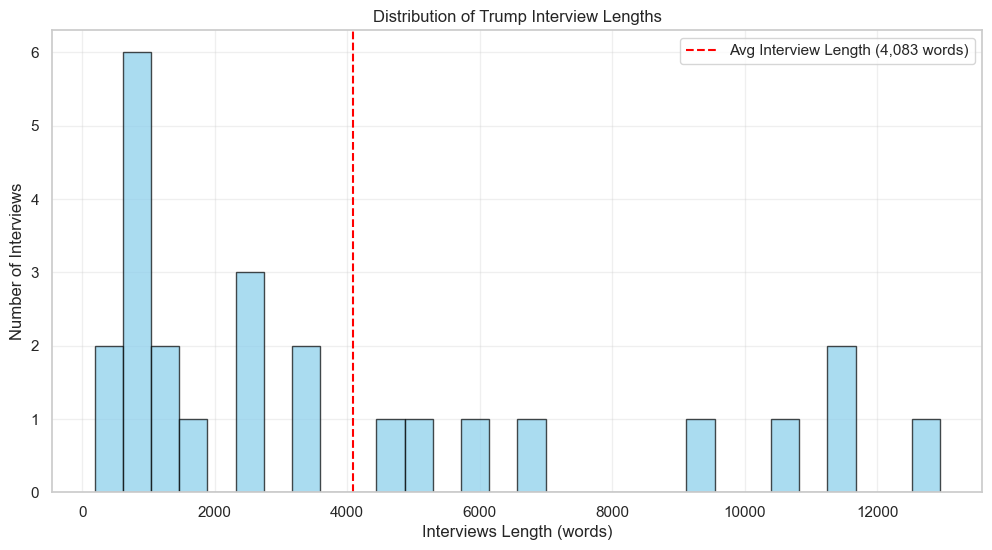

In [19]:
interview_mean_length = df_interviews['text_length'].mean()

# Plot distribution of speech lengths with interview average marked
plt.figure(figsize=(12, 6))
plt.hist(df_interviews['text_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=interview_mean_length, color='red', linestyle='--', label=f'Avg Interview Length ({int(interview_mean_length):,} words)')
plt.xlabel('Interviews Length (words)')
plt.ylabel('Number of Interviews')
plt.title('Distribution of Trump Interview Lengths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [20]:
# Get 10 shortest interviews
shortest_interviews = df_interviews.nsmallest(10, 'text_length')[['file', 'text_length', 'date']]
print("\nShortest 10 Interviews:")
print(shortest_interviews)



Shortest 10 Interviews:
                                                                                    file  \
224       2024-05-15_tom_hauser_of_kstp-tv_st_paul_minnesota_interviews_donald_trump.txt   
214                   2024-05-23_lawrence_jones_interviews_donald_trump_in_the_bronx.txt   
219   2024-05-16_charles_benson_of_scripps_news_interviews_donald_trump_in_milwaukee.txt   
215                 2024-05-21_josh_meny_of_ktvn_2_news_reno_interviews_donald_trump.txt   
208         2024-05-23_tara_rosenblum_of_news_12_westchester_interviews_donald_trump.txt   
230        2024-05-16_liz_collin_of_alpha_news_in_minnesota_interviews_donald_trump_.txt   
223  2025-02-09_bret_baier_of_fox_news_interviews_donald_trump_before_super_bowl_lix.txt   
211           2024-05-18_steven_dial_of_kdfw-tv_fox_4_dallas_interviews_donald_trump.txt   
210      2024-12-12_jim_cramer_of_cnbc_interviews_donald_trump_at_the_stock_exchange.txt   
222      2025-01-16_dan_bongino_interviews_donald_trump

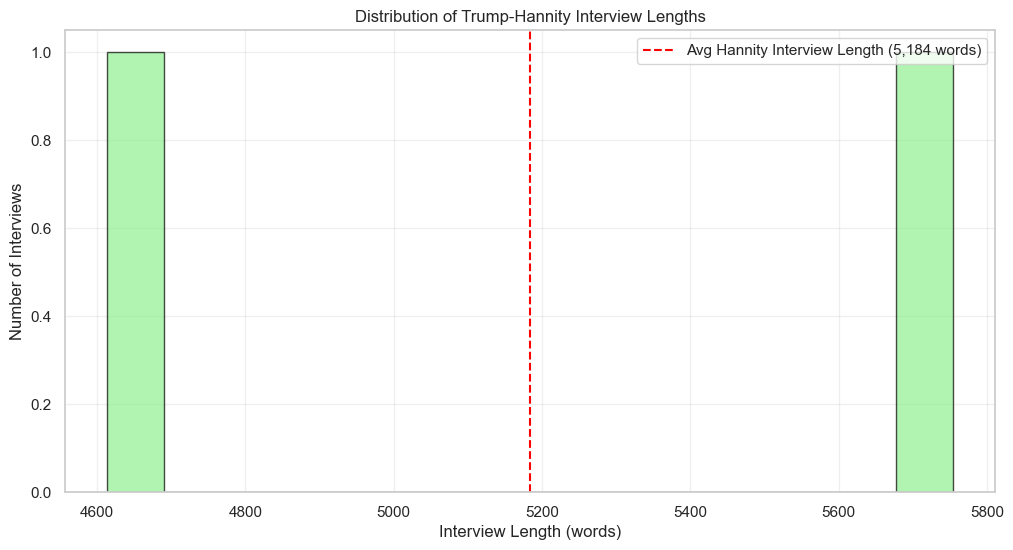


Hannity Interviews:
                                                                                   file  \
226                   2024-10-29_sean_hannity_interviews_donald_trump_at_mar-a-lago.txt   
220  2025-01-22_sean_hannity_interviews_donald_trump_in_the_oval_office_on_fox_news.txt   

     text_length       date  
226         4614 2024-10-29  
220         5754 2025-01-22  


In [49]:
# Find Hannity interviews
hannity_interviews = df_interviews[df_interviews['file'].str.contains('hannity', case=False)]

# Plot distribution of Hannity interview lengths
plt.figure(figsize=(12, 6))
plt.hist(hannity_interviews['text_length'], bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(x=hannity_interviews['text_length'].mean(), color='red', linestyle='--', 
            label=f'Avg Hannity Interview Length ({int(hannity_interviews["text_length"].mean()):,} words)')
plt.xlabel('Interview Length (words)')
plt.ylabel('Number of Interviews')
plt.title('Distribution of Trump-Hannity Interview Lengths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Display Hannity interview details
print("\nHannity Interviews:")
print(hannity_interviews[['file', 'text_length', 'date']].sort_values('date'))


In [50]:
# Calculate and display per-speech frequencies for each dataset
speech_freq_df_all = analyze_speech_frequencies(df_all, interview_mean_length)
speech_freq_df_all_post = analyze_speech_frequencies(df_all_post, interview_mean_length)
speech_freq_df_interviews = analyze_speech_frequencies(df_interviews, interview_mean_length)
speech_freq_df_interviews_post = analyze_speech_frequencies(df_interviews_post, interview_mean_length)

# Sort each by probability of at least one occurrence
speech_freq_df_all = speech_freq_df_all.sort_values('P(≥1)', ascending=False)
speech_freq_df_all_post = speech_freq_df_all_post.sort_values('P(≥1)', ascending=False)
speech_freq_df_interviews = speech_freq_df_interviews.sort_values('P(≥1)', ascending=False)
speech_freq_df_interviews_post = speech_freq_df_interviews_post.sort_values('P(≥1)', ascending=False)

# Format percentages for each dataframe
percentage_cols = ['P(≥1)', 'P(≥3)', 'P(≥4)', 'P(≥5)', 'P(≥15)']
for df in [speech_freq_df_all, speech_freq_df_all_post, 
           speech_freq_df_interviews, speech_freq_df_interviews_post]:
    for col in percentage_cols:
        df[col] = df[col].map('{:.1%}'.format)

# Display results
print("All appearances:")
display(speech_freq_df_all)
print("\nPost-Inauguration appearances:")
display(speech_freq_df_all_post)
print("\nAll Interviews:")
display(speech_freq_df_interviews)
print("\nPost-Inauguration Interviews:")
display(speech_freq_df_interviews_post)


All appearances:


,Phrase,Total Speeches,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Max Occurrences,Mean Occurrences
8,California,263,49.8%,22.4%,15.6%,8.7%,0.8%,40,1.653992
0,Immigration,263,46.4%,14.8%,6.5%,3.8%,0.0%,10,1.019011
1,America First,263,39.9%,7.2%,2.7%,0.4%,0.0%,5,0.669202
7,Saudi Arabia,263,34.6%,5.7%,1.5%,0.8%,0.0%,6,0.604563
4,Texas,263,31.9%,11.8%,7.2%,3.8%,0.8%,18,0.920152
2,Nancy,263,24.7%,12.2%,8.4%,5.3%,0.0%,8,0.783270
3,Chuck,263,10.3%,3.4%,1.5%,0.0%,0.0%,4,0.220532
5,Karoline,263,2.7%,1.5%,1.5%,1.1%,0.0%,6,0.095057
6,Paper Straw,263,1.1%,0.4%,0.0%,0.0%,0.0%,3,0.022814



Post-Inauguration appearances:


,Phrase,Total Speeches,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Max Occurrences,Mean Occurrences
8,California,58,27.6%,15.5%,12.1%,12.1%,0.0%,14,1.189655
7,Saudi Arabia,58,24.1%,3.4%,0.0%,0.0%,0.0%,3,0.413793
0,Immigration,58,13.8%,1.7%,0.0%,0.0%,0.0%,3,0.206897
2,Nancy,58,12.1%,6.9%,6.9%,3.4%,0.0%,6,0.413793
3,Chuck,58,12.1%,6.9%,1.7%,0.0%,0.0%,4,0.293103
1,America First,58,8.6%,0.0%,0.0%,0.0%,0.0%,2,0.120690
4,Texas,58,6.9%,3.4%,1.7%,1.7%,0.0%,7,0.206897
5,Karoline,58,5.2%,0.0%,0.0%,0.0%,0.0%,2,0.086207
6,Paper Straw,58,3.4%,0.0%,0.0%,0.0%,0.0%,2,0.051724



All Interviews:


,Phrase,Total Speeches,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Max Occurrences,Mean Occurrences
8,California,25,36.0%,24.0%,12.0%,8.0%,0.0%,10,1.28
0,Immigration,25,28.0%,4.0%,4.0%,4.0%,0.0%,5,0.56
4,Texas,25,20.0%,4.0%,4.0%,0.0%,0.0%,4,0.40
2,Nancy,25,16.0%,12.0%,12.0%,8.0%,0.0%,6,0.68
7,Saudi Arabia,25,16.0%,8.0%,0.0%,0.0%,0.0%,3,0.36
3,Chuck,25,8.0%,0.0%,0.0%,0.0%,0.0%,1,0.08
1,America First,25,4.0%,0.0%,0.0%,0.0%,0.0%,1,0.04
6,Paper Straw,25,4.0%,0.0%,0.0%,0.0%,0.0%,2,0.08
5,Karoline,25,0.0%,0.0%,0.0%,0.0%,0.0%,0,0.00



Post-Inauguration Interviews:


,Phrase,Total Speeches,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Max Occurrences,Mean Occurrences
0,Immigration,3,33.3%,0.0%,0.0%,0.0%,0.0%,1,0.333333
2,Nancy,3,33.3%,33.3%,33.3%,0.0%,0.0%,4,1.333333
6,Paper Straw,3,33.3%,0.0%,0.0%,0.0%,0.0%,2,0.666667
7,Saudi Arabia,3,33.3%,0.0%,0.0%,0.0%,0.0%,2,0.666667
8,California,3,33.3%,33.3%,33.3%,33.3%,0.0%,10,3.333333
1,America First,3,0.0%,0.0%,0.0%,0.0%,0.0%,0,0.000000
3,Chuck,3,0.0%,0.0%,0.0%,0.0%,0.0%,0,0.000000
4,Texas,3,0.0%,0.0%,0.0%,0.0%,0.0%,0,0.000000
5,Karoline,3,0.0%,0.0%,0.0%,0.0%,0.0%,0,0.000000


## Individual Phrase Analysis